# Assignment 1 2AMM10 2023-2024

## Group: Way Too Deep

### Member 1: Aniket Mishra

### Member 2: Anindita Sarkar

### Member 3: Mario Trabert


In [1]:
import os
import csv
import kagglehub
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display
from sklearn.manifold import TSNE

torch.multiprocessing.set_start_method("spawn", force=True)


class FashionDataset(Dataset):
    def __init__(
        self, csv_file, img_dir, column_class="articleTypeId", transform=None
    ):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(
            self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg"
        )  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

In [2]:
from dataset import FashionDataset

Download data with kagglehub


In [3]:
dataset_path = kagglehub.dataset_download(
    "paramaggarwal/fashion-product-images-small"
)
img_dir = os.path.join(dataset_path, "images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.


In [4]:
local_data_path = "./dataset"
dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
)

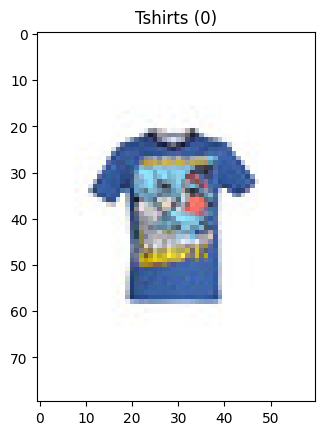

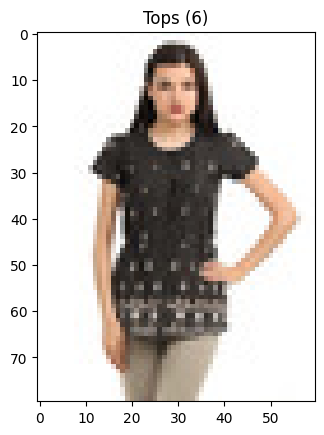

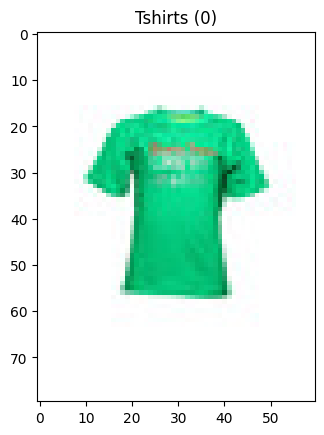

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset), 3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"] + f" ({label.item()})")
    plt.imshow(img)
    plt.show()

In [6]:
# Setting up default values, I forget to change them everywhere
batch_size = 512
learning_rate = 0.0001
all_birbs = sorted(list(set(dataset.targets)))
num_classes = len(set(dataset.targets))

resize_pixels_x = 128
resize_pixels_y = 128
crop_size = 128

## Loading different datasets


In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.RandomResizedCrop(
            crop_size
        ),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(
            (-15, 15), interpolation=InterpolationMode.NEAREST
        ),
        transforms.ColorJitter(brightness=0.1, contrast=0.15, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((resize_pixels_x, resize_pixels_y)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
    ]
)

In [8]:
train_dataset = FashionDataset(
    f"{local_data_path}/train.csv",
    img_dir,
    transform=transform,
)
main_test_dataset = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    transform=test_transform,
)
new_test_dataset = FashionDataset(
    f"{local_data_path}/new_test.csv",
    img_dir,
    transform=test_transform,
)
main_support_dataset = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    transform=test_transform,
)
new_support_dataset = FashionDataset(
    f"{local_data_path}/new_support.csv",
    img_dir,
    transform=test_transform,
)
merged_test_dataset = FashionDataset(
    f"{local_data_path}/merged_test.csv",
    img_dir,
    transform=test_transform,
)  # merged corresponds to main+new
merged_support_dataset = FashionDataset(
    f"{local_data_path}/merged_support.csv",
    img_dir,
    transform=test_transform,
)

# datasets with categories
main_test_dataset_cat = FashionDataset(
    f"{local_data_path}/main_test.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)
main_support_dataset_cat = FashionDataset(
    f"{local_data_path}/main_support.csv",
    img_dir,
    column_class="categoryId",
    transform=test_transform,
)


label_id_to_label_name = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i][
        "articleTypeName"
    ].iloc[0]
    for i in range(39)
}
label_id_to_label_name.update(
    {
        i: new_test_dataset.df[new_test_dataset.df["articleTypeId"] == i][
            "articleTypeName"
        ].iloc[0]
        for i in range(39, 39 + 30)
    }
)

## Task 1


In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False):
        super(ResidualBlock, self).__init__()

        stride = 2 if downsample else 1

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, stride=stride
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, padding=1
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNetCNN2(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(ResNetCNN2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2)

        self.layer1 = ResidualBlock(16, 32, downsample=False)
        self.layer2 = ResidualBlock(32, 64, downsample=True)
        self.layer3 = ResidualBlock(64, 128, downsample=True)
        self.layer4 = ResidualBlock(128, 256, downsample=True)

        self.dropout = nn.Dropout(0.1)

        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 128, 128)
            x = self.conv1(dummy_input)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.pool(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_embeddings(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        return x


print("ResNet CNN2 defined")

ResNet CNN2 defined


In [10]:
# Determine device depending on whether GPU is available
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(device)
print(torch.version.xpu)

mps
None


In [11]:
model = ResNetCNN2(in_channels=3, num_classes=num_classes)
model = model.to(device)

In [12]:
# Learning Rate Scheduler
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=7, gamma=0.1) # Example: reduce LR every 7 epochs

In [13]:
num_epochs = 100

print(f"Using device: {device}")
print(f"Number of classes: {num_classes}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning Rate Scheduler
# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


Using device: mps
Number of classes: 39
Batch size: 512
Learning rate: 0.0001


In [14]:
cpu_count = os.cpu_count()
cpu_count

12

# Train or not train model:


In [15]:
train_model = False

In [16]:
train_loader = DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True,
	num_workers=cpu_count-2,
	pin_memory=True if device in ["cuda", "mps"] else False
)

test_loader = DataLoader(
	dataset=main_test_dataset, 
	batch_size=batch_size,
	shuffle=False,
	num_workers=cpu_count-1,
	pin_memory=True if device == ["cuda", "mps"] else False
)

print(f"Train loader: {len(train_loader)} batches, {len(train_loader.dataset)} samples")
print(f"Test loader: {len(test_loader)} batches, {len(test_loader.dataset)} samples")

Train loader: 71 batches, 35934 samples
Test loader: 4 batches, 1997 samples


In [17]:

if 'train_dataset' not in locals() or 'main_test_dataset' not in locals():
	print("Please ensure train_dataset and main_test_dataset are defined.")
elif train_model == False:
    print("Not training the model.")
else:
	train_losses = []
	test_losses = []
	train_accuracies = []
	test_accuracies = []
	test_balanced_accuracies = []

	print("\nStarting training...")
	for epoch in range(num_epochs):
		print(epoch)
		model.train()
		running_loss = 0.0
		correct_train = 0
		total_train = 0
		epoch_start_time = time.time()

		for i, (images, labels) in enumerate(train_loader):
			images = images.to(device)
			labels = labels.to(device)

			outputs = model(images)
			loss = criterion(outputs, labels)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			running_loss += loss.item() * images.size(0) # loss.item() is avg loss for batch

			_, predicted = torch.max(outputs.data, 1)
			total_train += labels.size(0)
			correct_train += (predicted == labels).sum().item()

			if (i + 1) % (len(train_loader) // 4) == 0 and i != 0 : # Print progress a few times per epoch
					print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
						f"Batch Loss: {loss.item():.4f}")

		epoch_loss = running_loss / total_train
		epoch_acc = 100 * correct_train / total_train
		train_losses.append(epoch_loss)
		train_accuracies.append(epoch_acc)

		if 'scheduler' in locals():
			scheduler.step()

		model.eval()
		correct_test = 0
		total_test = 0
		running_test_loss = 0.0
		all_test_preds = []
		all_test_labels = []

		with torch.no_grad(): 
			for images, labels in test_loader:
				images = images.to(device)
				labels = labels.to(device)

				outputs = model(images)
				loss = criterion(outputs, labels)
				running_test_loss += loss.item() * images.size(0)

				_, predicted = torch.max(outputs.data, 1)
				total_test += labels.size(0)
				correct_test += (predicted == labels).sum().item()
				all_test_preds.extend(predicted.cpu().numpy())
				all_test_labels.extend(labels.cpu().numpy())

		epoch_test_loss = running_test_loss / total_test
		epoch_test_acc = 100 * correct_test / total_test
		epoch_test_balanced_acc = balanced_accuracy_score(all_test_labels, all_test_preds) * 100

		test_losses.append(epoch_test_loss)
		test_accuracies.append(epoch_test_acc)
		test_balanced_accuracies.append(epoch_test_balanced_acc)

		epoch_end_time = time.time()
		epoch_duration = epoch_end_time - epoch_start_time

		print(f"Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f}s:")
		print(f"  Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")
		print(f"  Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.2f}%, Test Balanced Accuracy: {epoch_test_balanced_acc:.2f}%")
		if epoch_test_acc >= 75 and epoch_test_balanced_acc >= 75:
			print(f"  Performance target reached on main classes test set at epoch {epoch+1}!")


	print("\nFinished Training.")

	plt.figure(figsize=(18, 5))

	plt.subplot(1, 3, 1)
	plt.plot(train_losses, label="Training Loss")
	plt.plot(test_losses, label="Test Loss (Main Classes)")
	plt.title("Loss over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.grid(True)

	plt.subplot(1, 3, 2)
	plt.plot(train_accuracies, label="Training Accuracy")
	plt.plot(test_accuracies, label="Test Accuracy (Main Classes)")
	plt.title("Accuracy over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Accuracy (%)")
	plt.legend()
	plt.grid(True)

	plt.subplot(1, 3, 3)
	plt.plot(test_balanced_accuracies, label="Test Balanced Accuracy (Main Classes)")
	plt.title("Balanced Accuracy (Test) over epochs")
	plt.xlabel("Epoch")
	plt.ylabel("Balanced Accuracy (%)")
	plt.legend()
	plt.grid(True)

	plt.tight_layout()
	plt.show()

	os.makedirs("outputs/images", exist_ok=True)
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")

	plot_save_path = f"outputs/images/training_curves_{timestamp}.png"
	plt.savefig(plot_save_path)


Not training the model.


Saving dem models ez


In [18]:
if train_model == True:
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")

	save_path = f"outputs/models/resnetcnn2_task1_epochs_{num_epochs}_{timestamp}.pth"
	torch.save(model.state_dict(), save_path)
	print(f"Model saved to {save_path}")

	save_path = f"outputs/models/resnetcnn2_task1__epochs_{num_epochs}.pth"
	torch.save(model.state_dict(), save_path)
	print(f"Model saved to {save_path}")
else:
    print("Did not train model, not saving.")

Did not train model, not saving.


## Task 2


In [19]:
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)


In [20]:
model = ResNetCNN2(in_channels=3, num_classes=39)
model.load_state_dict(torch.load("outputs/models/resnetcnn2_task1.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready for Task 2")


Model loaded and ready for Task 2


In [21]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            emb = model.get_embeddings(images).cpu()
            embeddings.append(emb)
            labels.append(lbls)
    return torch.cat(embeddings), torch.cat(labels)


def classify_with_support(query_embeddings, support_embeddings, support_labels, k=1):
    distances = torch.cdist(query_embeddings, support_embeddings)  # shape: [N_query, N_support]
    topk_indices = distances.topk(k, largest=False).indices       # shape: [N_query, k]
    topk_labels = support_labels[topk_indices]                    # shape: [N_query, k]
    pred_labels = torch.mode(topk_labels, dim=1).values
    return pred_labels


def evaluate_with_support(model, support_dataset, test_dataset, device, batch_size=512, k=1):
    support_loader = DataLoader(support_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    support_embeddings, support_labels = extract_embeddings(model, support_loader, device)
    test_embeddings, test_labels = extract_embeddings(model, test_loader, device)

    pred_labels = classify_with_support(test_embeddings, support_embeddings, support_labels, k)

    acc = (pred_labels == test_labels).float().mean().item() * 100
    bal_acc = balanced_accuracy_score(test_labels.numpy(), pred_labels.numpy()) * 100
    return acc, bal_acc


In [22]:
print("\nEvaluating Task 2 Scenarios...\n")

scenarios = {
    "Scenario 1 (Train support → Main test)": (train_dataset, main_test_dataset),
    "Scenario 2 (Main support → Main test)": (main_support_dataset, main_test_dataset),
    "Scenario 3 (New support → New test)": (new_support_dataset, new_test_dataset),
    "Scenario 4 (Merged support → Merged test)": (merged_support_dataset, merged_test_dataset),
}

for name, (support_set, test_set) in scenarios.items():
	acc, bal_acc = evaluate_with_support(model, support_set, test_set, device)
	print(f"{name}:")
	print(f"  Accuracy:         {acc:.2f}%")
	print(f"  Balanced Accuracy:{bal_acc:.2f}%\n")

	scenario_id = name.split("(")[0].strip().replace(" ", "_").lower()
	timestamp = datetime.now().strftime("%Y%m%d_%H%M")
	model_save_path = f"outputs/models/resnetcnn2_task2_epochs_{num_epochs}_{scenario_id}_{timestamp}.pth"

	torch.save(model.state_dict(), model_save_path)
	print(f"Saved model to {model_save_path}\n")



Evaluating Task 2 Scenarios...

Scenario 1 (Train support → Main test):
  Accuracy:         80.77%
  Balanced Accuracy:76.87%

Saved model to outputs/models/resnetcnn2_task2_epochs_100_scenario_1_20250526_2329.pth

Scenario 2 (Main support → Main test):
  Accuracy:         80.92%
  Balanced Accuracy:75.26%

Saved model to outputs/models/resnetcnn2_task2_epochs_100_scenario_2_20250526_2329.pth

Scenario 3 (New support → New test):
  Accuracy:         80.42%
  Balanced Accuracy:80.06%

Saved model to outputs/models/resnetcnn2_task2_epochs_100_scenario_3_20250526_2329.pth

Scenario 4 (Merged support → Merged test):
  Accuracy:         74.02%
  Balanced Accuracy:68.90%

Saved model to outputs/models/resnetcnn2_task2_epochs_100_scenario_4_20250526_2329.pth



## Task 3


In [23]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

In [24]:
model = ResNetCNN2(in_channels=3, num_classes=39)  # 64 classes for scenario 4
model.load_state_dict(torch.load("outputs/models/resnetcnn2_task2_epochs_100_scenario_4_20250526_1232.pth", map_location=device))
model = model.to(device)
model.eval()
print("Model loaded and ready for Task 3")

Model loaded and ready for Task 3


In [25]:
TOP_K = 3
CONFIDENCE_THRESHOLD = 0.4

def precision_at_k(retrieved_labels, true_label, k=None):
    """
    Computes Precision@k.
    If k is None, use full length of retrieved_labels.
    """
    if k is None:
        k = len(retrieved_labels)
    correct = sum(1 for i in range(k) if retrieved_labels[i] == true_label)
    return correct / k

def unnormalize(tensor_img):
    """
    Converts a normalized tensor image in [-1, 1] range back to [0, 1] for plotting.
    This is essentially a helper function that averts redundant output during plot creation.
    """
    return tensor_img * 0.5 + 0.5  # inverse of Normalize(mean=0.5, std=0.5)

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels, indices = [], [], []
    with torch.no_grad():
        for i, (images, lbls) in enumerate(dataloader):
            images = images.to(device)
            emb = model.get_embeddings(images).cpu()
            embeddings.append(emb)
            labels.append(lbls)
            # Save the true DataFrame indices
            indices.extend(dataloader.dataset.df.index[i * dataloader.batch_size : i * dataloader.batch_size + len(lbls)])
    return torch.cat(embeddings), torch.cat(labels), indices


def visualize_recommendations(query_img, rec_imgs, query_title="Query", rec_titles=None):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, len(rec_imgs) + 1, 1)
    plt.imshow(unnormalize(query_img.permute(1, 2, 0)))
    plt.title(query_title)
    plt.axis("off")
    
    for i, img in enumerate(rec_imgs):
        plt.subplot(1, len(rec_imgs) + 1, i + 2)
        plt.imshow(unnormalize(img.permute(1, 2, 0)))
        title = f"Top-{i+1}" if rec_titles is None else rec_titles[i]
        plt.title(title)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


def recommend_similar_images(model, query_dataset, support_dataset, device, k=3, support_idx_mapping=None, threshold=0.2):
    support_loader = DataLoader(support_dataset, batch_size=128, shuffle=False)
    support_embeddings, support_labels, _ = extract_embeddings(model, support_loader, device)

    idx = np.random.randint(0, len(query_dataset))
    query_img, query_label = query_dataset[idx]
    query_label = query_label.item() if torch.is_tensor(query_label) else int(query_label)
    query_img_input = query_img.unsqueeze(0).to(device)
    query_embedding = model.get_embeddings(query_img_input).cpu()

    distances = torch.cdist(query_embedding, support_embeddings)[0]
    topk = torch.topk(distances, k=k, largest=False)
    topk_indices = topk.indices

    softmax_confs_all = F.softmax(-distances, dim=0)
    softmax_confs_topk = softmax_confs_all[topk_indices]
    max_conf = softmax_confs_topk.max().item()

    rec_imgs, rec_labels, titles = [], [], []
    for i, sc in zip(topk_indices, softmax_confs_topk):
        true_idx = support_idx_mapping[i.item()]
        img, label = support_dataset[true_idx]
        rec_imgs.append(img)
        rec_labels.append(int(label))
        titles.append(f"Label: {label}\nConf: {sc:.2f}")

    visualize_recommendations(query_img, rec_imgs, rec_titles=titles)

    if max_conf < threshold:
        print(f"Recommendation NOT shown to user (confidence {max_conf:.2f} < threshold {threshold:.2f})")
    else:
        print(f"Recommendation shown to user (confidence {max_conf:.2f} ≥ threshold {threshold:.2f})")

    print(f"Query label: {query_label} - {label_id_to_label_name[query_label]}")
    print(f"Top-{k} recommended labels: {[f'{l} - {label_id_to_label_name[l]}' for l in rec_labels]}")
    print(f"Confidence scores: {[round(c.item(), 3) for c in softmax_confs_topk]}")

    correct = int(query_label in rec_labels)
    print(f"Correct recommendation: {'Yes' if correct else 'No'}")




def run_recommendation_system(model, query_dataset, support_dataset, device, k=3, num_queries=5, seed=42):
    """
    Runs and visualizes recommendations for num_queries random queries.
    """
    np.random.seed(seed)

    support_idx_mapping = list(support_dataset.df.index)

    print(f"\nSupport set size: {len(support_idx_mapping)}")

    for i in range(num_queries):
        print(f"\nRecommendation #{i+1}")
        recommend_similar_images(
            model=model,
            query_dataset=query_dataset,
            support_dataset=support_dataset,
            device=device,
            k=k,
            support_idx_mapping=support_idx_mapping,
            threshold=CONFIDENCE_THRESHOLD
        )


In [26]:
if train_model == True:
	run_recommendation_system(
		model=model,
		query_dataset=merged_test_dataset,
		support_dataset=merged_support_dataset,
		device=device,
		k=TOP_K,
		num_queries=5
	)


In [27]:
def evaluate_recommendation_system(
    model,
    query_dataset,
    support_dataset,
    device,
    thresholds=None,
    num_queries=100,
    k=3
):
    """
    Evaluate the recommendation system over different confidence thresholds.

    For each query:
        - Retrieve top-k most similar items from the support set (catalog)
        - Use softmax-based confidence
        - Only recommend if max confidence >= threshold
        - Consider the recommendation correct if ≥1 item matches query class

    Plot error rate (%) vs. coverage (%)
    """

    if thresholds is None:
        thresholds = np.linspace(0.0, 0.9, 10)

    support_loader = DataLoader(support_dataset, batch_size=128, shuffle=False)
    support_embeddings, _, _ = extract_embeddings(model, support_loader, device)
    support_idx_mapping = list(support_dataset.df.index)

    error_rates_percent = []
    coverages_percent = []

    for threshold in thresholds:
        num_displayed = 0
        num_correct = 0

        for _ in range(num_queries):
            idx = np.random.randint(0, len(query_dataset))
            query_img, query_label = query_dataset[idx]
            query_label = query_label.item() if torch.is_tensor(query_label) else int(query_label)
            query_img_input = query_img.unsqueeze(0).to(device)
            query_embedding = model.get_embeddings(query_img_input).cpu()

            distances = torch.cdist(query_embedding, support_embeddings)[0]
            topk = torch.topk(distances, k=k, largest=False)
            topk_indices = topk.indices

            softmax_conf_all = F.softmax(-distances, dim=0)
            topk_conf = softmax_conf_all[topk_indices]
            max_conf = topk_conf.max().item()

            if max_conf >= threshold:
                num_displayed += 1
                retrieved_labels = [int(support_dataset[support_idx_mapping[i.item()]][1]) for i in topk_indices]
                if query_label in retrieved_labels:
                    num_correct += 1

        if num_displayed > 0:
            error_rate = 100 * (1 - (num_correct / num_displayed))
        else:
            error_rate = 0.0

        coverage = 100 * (num_displayed / num_queries)

        error_rates_percent.append(error_rate)
        coverages_percent.append(coverage)

        print(f"Threshold: {threshold:.2f} | Error Rate: {error_rate:.1f}% | Coverage: {coverage:.1f}%")

    os.makedirs("outputs/evaluation", exist_ok=True)
    csv_path = os.path.join("outputs/evaluation", "task3_error_vs_coverage.csv")
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Threshold", "Error Rate (%)", "Coverage (%)"])
        for t, e, c in zip(thresholds, error_rates_percent, coverages_percent):
            writer.writerow([round(t, 2), round(e, 1), round(c, 1)])

    print(f"\nResults saved to: {csv_path}")


    plt.figure(figsize=(8, 6))
    sorted_points = sorted(zip(error_rates_percent, coverages_percent))
    x, y = zip(*sorted_points)
    plt.plot(x, y, marker='o')
    plt.xlabel("Error Rate (%)")
    plt.ylabel("Coverage (%)")
    plt.title("Error Rate vs. Coverage (Recommendation System)")
    plt.grid(True)
    plt.show()

In [28]:
csv_path = "outputs/evaluation/task3_error_vs_coverage.csv"

df_results = pd.read_csv(csv_path)
display(df_results.style.set_caption("Task 3 Evaluation: Error Rate vs. Coverage by Threshold")
                     .format({"Threshold": "{:.2f}", "Error Rate (%)": "{:.1f}", "Coverage (%)": "{:.1f}"}))


,Threshold,Error Rate (%),Coverage (%)
0,0.00,13.8,100.0
1,0.10,13.3,99.9
2,0.20,12.6,98.0
3,0.30,12.3,90.0
4,0.40,11.1,77.5
5,0.50,9.8,64.7
6,0.60,9.7,51.2
7,0.70,8.8,42.1
8,0.80,7.8,32.9
9,0.90,9.2,21.5


In [29]:
if train_model == True:
	evaluate_recommendation_system(
		model=model,
		query_dataset=merged_test_dataset,
		support_dataset=merged_support_dataset,
		device=device,
		k=3,
		thresholds=np.linspace(0.0, 0.9, 10),
		num_queries=3600
	)

## Task 4


### Step 1


In [30]:
article_to_category = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    for i in range(39)
}
article_to_category.update({
    i: new_test_dataset.df[new_test_dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    for i in range(39, 39 + 30)
})


In [31]:
train_dataset.df.head(2)

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0


In [32]:
train_dataset.df[["articleTypeName", "articleTypeId", "categoryId"]].value_counts()

articleTypeName        articleTypeId  categoryId
Tshirts                0              0             6339
Shirts                 1              0             2906
Casual Shoes           2              1             2552
Watches                3              3             2282
Sports Shoes           4              1             1834
Kurtas                 5              0             1661
Handbags               7              2             1580
Tops                   6              0             1566
Heels                  8              1             1212
Sunglasses             9              7              979
Flip Flops             11             11             834
Wallets                10             10             830
Sandals                12             9              805
Briefs                 13             5              756
Belts                  14             12             720
Backpacks              15             2              659
Socks                  16             1

In [33]:
model = ResNetCNN2(in_channels=3, num_classes=39)
model.load_state_dict(torch.load(
    "outputs/models/resnetcnn2_task1.pth", map_location=device))
model = model.to(device)
model.eval()

ResNetCNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): Ba

In [34]:
features = []
labels = []
img_indices = []

with torch.no_grad():
    for batch_idx, (images, lbls) in enumerate(train_loader):
        mask = (lbls < 10)
        if not mask.any():
            continue
        images = images[mask].to(device)
        lbls = lbls[mask]
        if len(lbls) == 0:
            continue
        emb = model.get_embeddings(images)
        features.append(emb.cpu().numpy())
        labels.append(lbls.cpu().numpy())
        base_idx = batch_idx * train_loader.batch_size
        batch_indices = np.arange(base_idx, base_idx + len(mask))[mask.cpu().numpy()]
        img_indices.extend(batch_indices)

features = np.concatenate(features)
labels = np.concatenate(labels)
img_indices = np.array(img_indices)


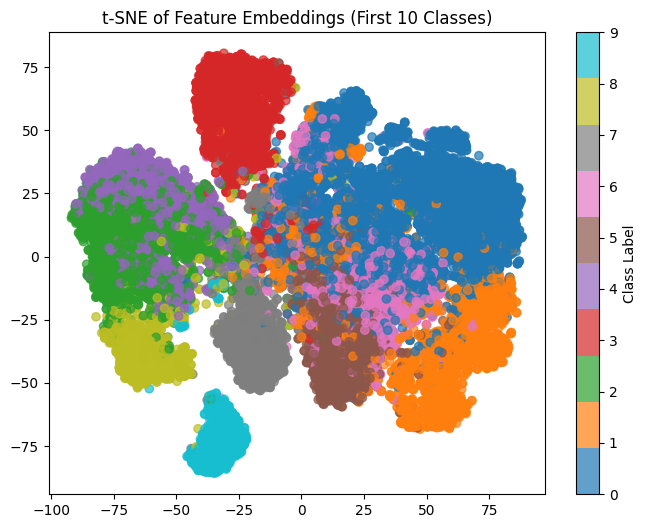

In [35]:
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.title('t-SNE of Feature Embeddings (First 10 Classes)')
plt.show()

In [36]:
features_test = []
labels_test = []
img_indices_test = []

with torch.no_grad():
    curr_idx = 0
    for images, lbls in test_loader:
        mask = (lbls < 10)
        if not mask.any():
            curr_idx += len(lbls)
            continue
        images = images[mask].to(device)
        lbls = lbls[mask]
        if len(lbls) == 0:
            curr_idx += len(lbls)
            continue
        emb = model.get_embeddings(images)
        features_test.append(emb.cpu().numpy())
        labels_test.append(lbls.cpu().numpy())
        # Track dataset indices for this batch
        img_indices_test.extend(range(curr_idx, curr_idx + len(lbls)))
        curr_idx += len(lbls)

features_test = np.concatenate(features_test)
labels_test = np.concatenate(labels_test)
img_indices_test = np.array(img_indices_test)
print("Test feature shape:", features_test.shape)
print("Test img_indices_test shape:", img_indices_test.shape)


Test feature shape: (1253, 256)
Test img_indices_test shape: (1253,)


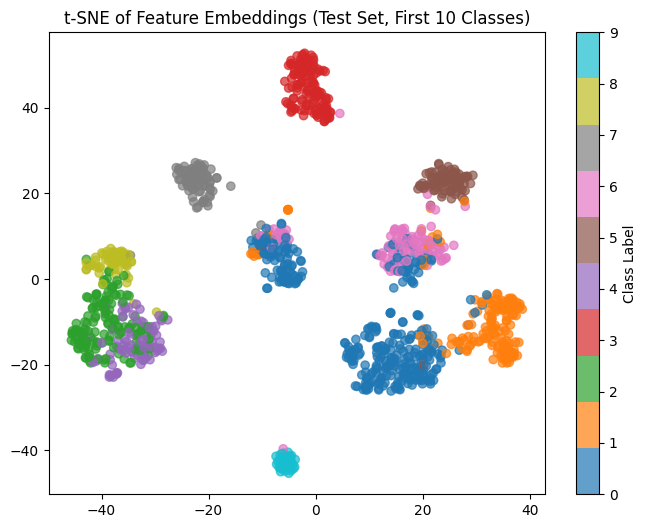

In [37]:
X_embedded_test = TSNE(n_components=2, random_state=42).fit_transform(features_test)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded_test[:, 0], X_embedded_test[:, 1], c=labels_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Class Label')
plt.title('t-SNE of Feature Embeddings (Test Set, First 10 Classes)')
plt.show()

### Step 2


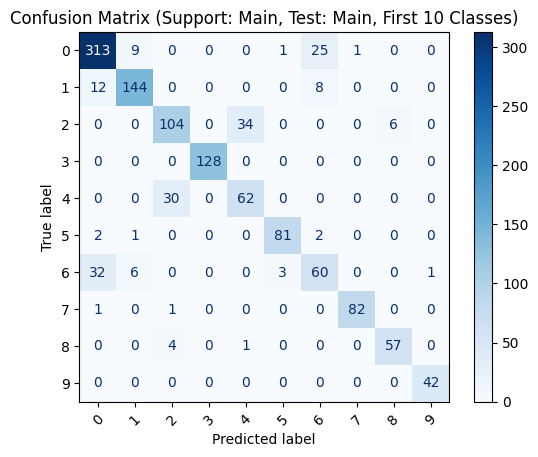

In [38]:
def filter_first_10(dataset):
    indices = [i for i in range(len(dataset)) if dataset[i][1] < 10]
    from torch.utils.data import Subset
    return Subset(dataset, indices)

support_first10 = filter_first_10(main_support_dataset)
test_first10 = filter_first_10(main_test_dataset)

support_loader = DataLoader(support_first10, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_first10, batch_size=batch_size, shuffle=False)

def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            emb = model.get_embeddings(images).cpu()
            embeddings.append(emb)
            labels.append(lbls)
    return torch.cat(embeddings), torch.cat(labels)

support_embeddings, support_labels = extract_embeddings(model, support_loader, device)
test_embeddings, test_labels = extract_embeddings(model, test_loader, device)

def classify_with_support(query_embeddings, support_embeddings, support_labels, k=1):
    distances = torch.cdist(query_embeddings, support_embeddings)
    topk_indices = distances.topk(k, largest=False).indices
    topk_labels = support_labels[topk_indices]
    pred_labels = torch.mode(topk_labels, dim=1).values
    return pred_labels

pred_labels = classify_with_support(test_embeddings, support_embeddings, support_labels, k=1)

all_preds = pred_labels.cpu().numpy()
all_labels = test_labels.cpu().numpy()

cm = confusion_matrix(test_labels.numpy(), pred_labels.numpy(), labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Support: Main, Test: Main, First 10 Classes)")
plt.show()

### Step 3


In [39]:
def compute_centroid(features, labels, class_idx):
    feats = features[labels == class_idx]
    return feats.mean(axis=0)

tshirt_idx = 0
shirt_idx = 1

centroid_tshirt_train = compute_centroid(features, labels, tshirt_idx)
centroid_shirt_train = compute_centroid(features, labels, shirt_idx)

centroid_tshirt_test = compute_centroid(features_test, labels_test, tshirt_idx)
centroid_shirt_test = compute_centroid(features_test, labels_test, shirt_idx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


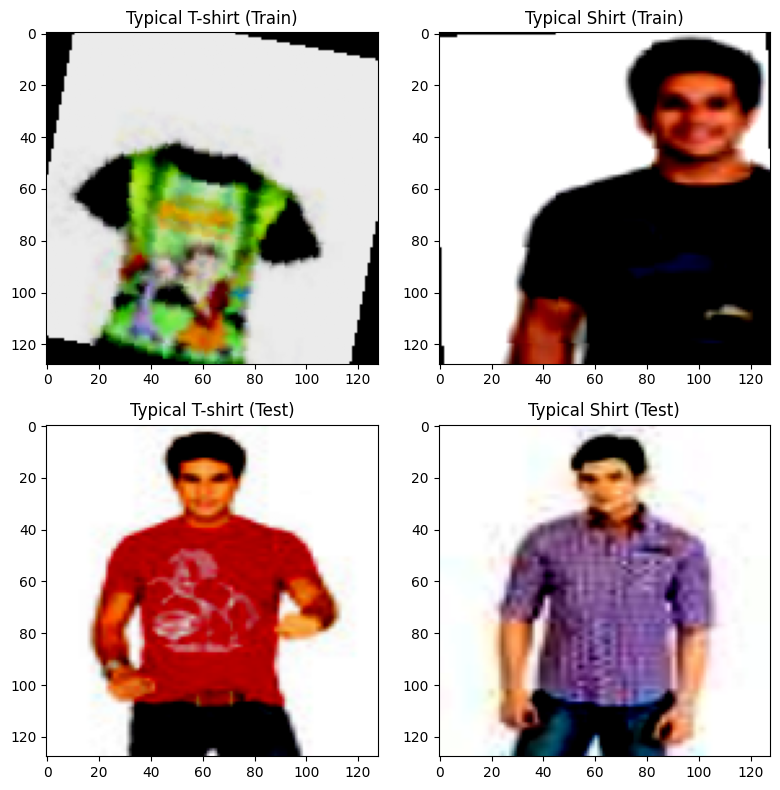

In [40]:
def closest_image_idx(features, centroid):
    dists = np.linalg.norm(features - centroid, axis=1)
    return np.argmin(dists)

idx_typical_tshirt_train = closest_image_idx(features, centroid_tshirt_train)
idx_typical_shirt_train = closest_image_idx(features, centroid_shirt_train)

idx_typical_tshirt_test = closest_image_idx(features_test, centroid_tshirt_test)
idx_typical_shirt_test = closest_image_idx(features_test, centroid_shirt_test)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0,0].imshow(train_loader.dataset[img_indices[idx_typical_tshirt_train]][0].permute(1,2,0))
axs[0,0].set_title("Typical T-shirt (Train)")
axs[0,1].imshow(train_loader.dataset[img_indices[idx_typical_shirt_train]][0].permute(1,2,0))
axs[0,1].set_title("Typical Shirt (Train)")
axs[1,0].imshow(test_loader.dataset[img_indices_test[idx_typical_tshirt_test]][0].permute(1,2,0))
axs[1,0].set_title("Typical T-shirt (Test)")
axs[1,1].imshow(test_loader.dataset[img_indices_test[idx_typical_shirt_test]][0].permute(1,2,0))
axs[1,1].set_title("Typical Shirt (Test)")
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.75686276].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9607843].


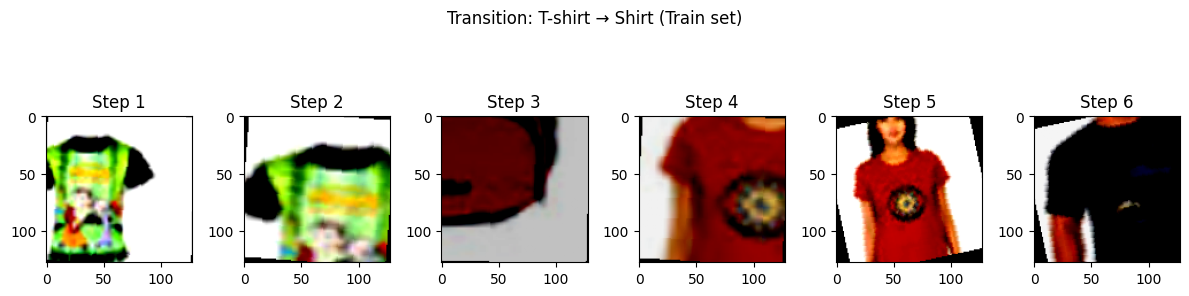

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].


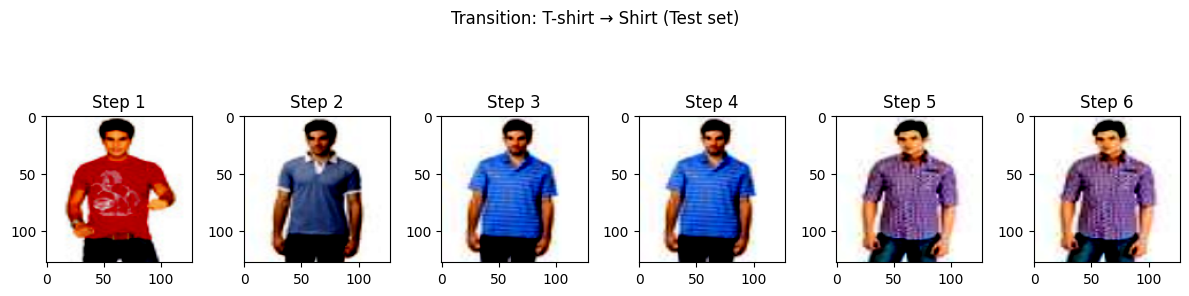

In [41]:
num_steps = 6
transitions_train = [
    centroid_tshirt_train + (centroid_shirt_train - centroid_tshirt_train) * i/(num_steps-1)
    for i in range(num_steps)
]
closest_idxs_train = [closest_image_idx(features, pt) for pt in transitions_train]

fig, axs = plt.subplots(1, num_steps, figsize=(num_steps*2, 3))
for i, idx in enumerate(closest_idxs_train):
    axs[i].imshow(train_loader.dataset[img_indices[idx]][0].permute(1,2,0))
    axs[i].set_title(f"Step {i+1}")
plt.tight_layout()
plt.suptitle("Transition: T-shirt → Shirt (Train set)", y=1.1)
plt.show()

transitions_test = [
    centroid_tshirt_test + (centroid_shirt_test - centroid_tshirt_test) * i/(num_steps-1)
    for i in range(num_steps)
]
closest_idxs_test = [closest_image_idx(features_test, pt) for pt in transitions_test]

fig, axs = plt.subplots(1, num_steps, figsize=(num_steps*2, 3))
for i, idx in enumerate(closest_idxs_test):
    axs[i].imshow(test_loader.dataset[img_indices_test[idx]][0].permute(1,2,0))
    axs[i].set_title(f"Step {i+1}")
plt.tight_layout()
plt.suptitle("Transition: T-shirt → Shirt (Test set)", y=1.1)
plt.show()


### Step 4


In [42]:
unique_type_ids = np.unique(
    np.concatenate([
        train_dataset.df["articleTypeId"].unique(),
        main_test_dataset.df["articleTypeId"].unique()
    ])
)

article_to_category = {
    i: train_dataset.df[train_dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    if i in train_dataset.df["articleTypeId"].unique()
    else main_test_dataset.df[test_loader.dataset.df["articleTypeId"] == i]["categoryId"].iloc[0]
    for i in unique_type_ids
}

category_preds = np.array([article_to_category[int(p)] for p in all_preds])
category_labels = np.array([article_to_category[int(y)] for y in all_labels])


Category-level accuracy: 0.9968
Category-level balanced accuracy: 0.9947


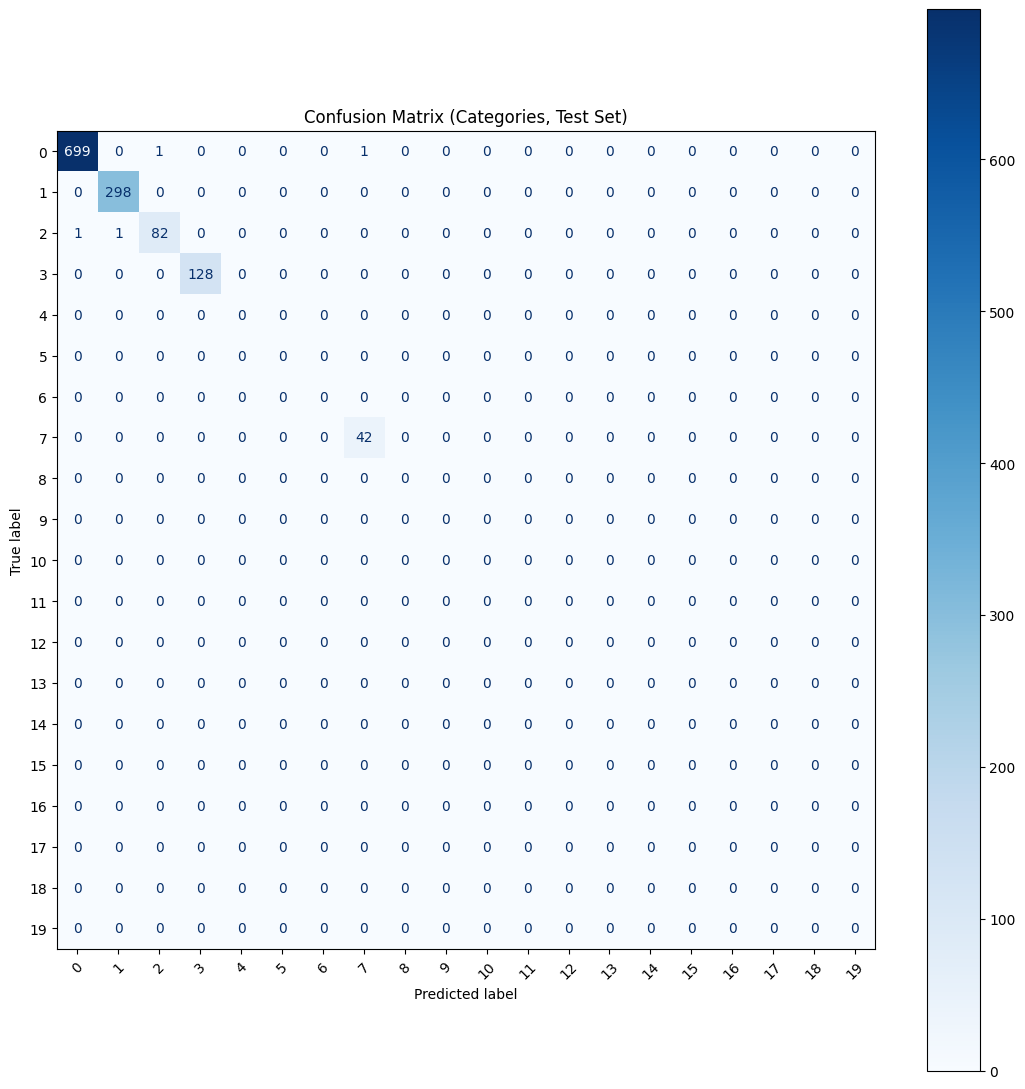

In [43]:
cat_acc = accuracy_score(category_labels, category_preds)
cat_bal_acc = balanced_accuracy_score(category_labels, category_preds)
print(f"Category-level accuracy: {cat_acc:.4f}")
print(f"Category-level balanced accuracy: {cat_bal_acc:.4f}")

num_cats = len(set(article_to_category.values()))
cm_cat = confusion_matrix(category_labels, category_preds, labels=range(num_cats))

fig, ax = plt.subplots(figsize=(11, 11))
disp_cat = ConfusionMatrixDisplay(confusion_matrix=cm_cat, display_labels=range(num_cats))
disp_cat.plot(cmap='Blues', xticks_rotation=45, ax=ax)
plt.title("Confusion Matrix (Categories, Test Set)")
plt.tight_layout()
plt.show()